<a href="https://colab.research.google.com/github/KevinTheRainmaker/AI-ML_Team_5/blob/main/KangbeenKo/Kaggle02_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Novice to Grandmaster
### Competition #2: Natural Language Processing with Disaster Tweets

- https://www.kaggle.com/c/nlp-getting-started

[설명]

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. 

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path = '/content/drive/MyDrive/data/Kaggle'

Mounted at /content/drive


In [2]:
# Packages
import os

import pandas as pd
import numpy as np
import math, re, time, random, string

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict
import wordcloud

from tqdm import tqdm, tqdm_pandas
tqdm_pandas(tqdm())

import warnings
warnings.filterwarnings(action='ignore')

!pip install -q --upgrade --force-reinstall --no-deps kaggle
os.environ['KAGGLE_USERNAME'] = 'kangbeenko'
os.environ['KAGGLE_KEY'] = '7bf5875a0067e432fb8a9300acd60b8e'

0it [00:00, ?it/s]


     |████████████████████████████████| 58 kB 3.0 MB/s 


## Dataset

In [3]:
!kaggle competitions download -c nlp-getting-started
!mv nlp-getting-started.zip drive/MyDrive/data/Kaggle/

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 115MB/s]


In [4]:
!unzip drive/MyDrive/data/Kaggle/nlp-getting-started.zip

Archive:  drive/MyDrive/data/Kaggle/nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [41]:
!unzip drive/MyDrive/data/Kaggle/glove.twitter.27B.zip

Archive:  drive/MyDrive/data/Kaggle/glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [6]:
train_df=pd.read_csv('./train.csv')
test_df=pd.read_csv('./test.csv')

print("Trainset counts: ", train_df['id'].count())
print("Testset counts: ", test_df['id'].count())

Trainset counts:  7613
Testset counts:  3263


In [7]:
train_df.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [8]:
test_df.tail()

,id,keyword,location,text
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...


target이 1이면 disaster tweet이고, 0인 경우 disaster tweet이 아니다.

In [9]:
print(train_df[train_df["target"] == 0]["text"].values[1])
print(train_df[train_df["target"] == 1]["text"].values[1])

I love fruits
Forest fire near La Ronge Sask. Canada


In [10]:
print(train_df[train_df["keyword"].notnull()].iloc[0])

id                                                         48
keyword                                                ablaze
location                                           Birmingham
text        @bbcmtd Wholesale Markets ablaze http://t.co/l...
target                                                      1
Name: 31, dtype: object


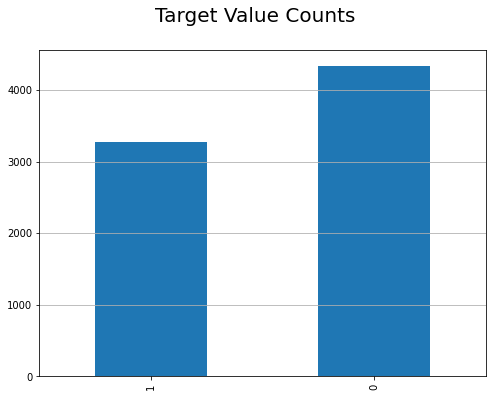

In [11]:
# Plotting target value counts
plt.figure(figsize=(8,6))
ax = train_df['target'].value_counts().sort_values().plot(kind="bar")
ax.grid(axis="y")
plt.suptitle("Target Value Counts", fontsize=20)
plt.show()

In [12]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

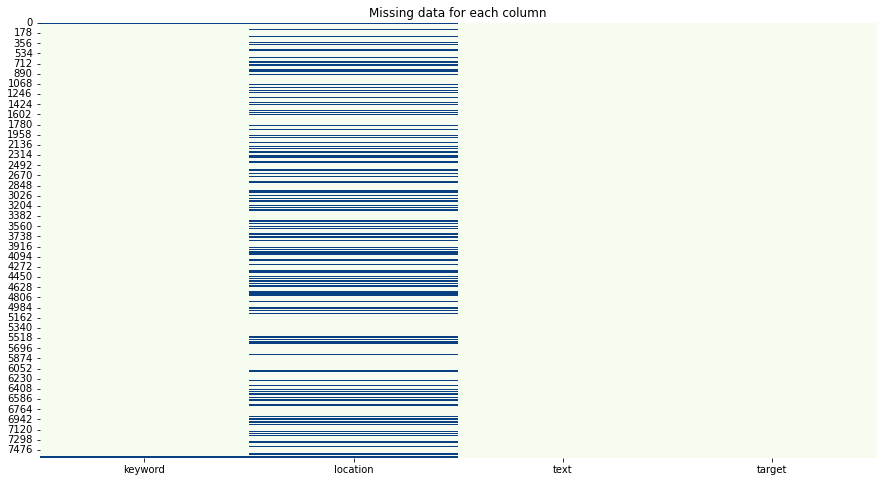

In [13]:
plt.figure(figsize=(15,8))
sns.heatmap(train_df.drop('id', axis=1).isnull(), cbar=False, cmap="GnBu").set_title("Missing data for each column")
plt.show()

In [14]:
lengths = np.array([len(x) for x in train_df['text']])
print(np.mean(lengths), np.median(lengths))

101.03743596479706 107.0


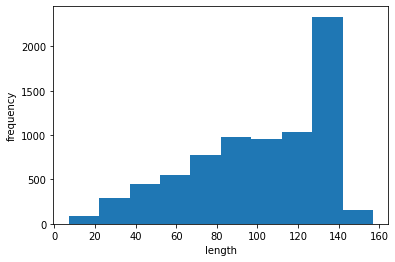

In [15]:
plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

## Cleaning

In [16]:
#install autocorrect
!pip install autocorrect
from autocorrect import Speller 

#create function to spell check strings
def spell_check(x):
    spell = Speller(lang='en')
    return " ".join([spell(i) for i in x.split()])

#showcase spellcheck 
mispelled = 'Pleaze spel check this sentince'
spell_check(mispelled)

     |████████████████████████████████| 622 kB 5.7 MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622382 sha256=032186d270c75ef317bd915ca72a02717051b391a671f5138ca22ef514b25de8
  Stored in directory: /root/.cache/pip/wheels/54/d4/37/8244101ad50b0f7d9bffd93ce58ed7991ee1753b290923934b
Successfully built autocorrect


'Please spell check this sentence'

In [17]:
#remove punctuation
def remove_punctuation(x):
    return x.translate(str.maketrans('', '', string.punctuation))

#remove stopwords
def remove_stopwords(x):
    return ' '.join([i for i in x.split() if i not in wordcloud.STOPWORDS])

#remove words with non-alphabet characters
def remove_non_alphabet(x):
    return ' '.join([i for i in x.split() if i.isalpha()])

def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

In [18]:
total = [train_df, test_df]
for dataset in total:
    #apply all of above functions
    dataset['text'] = dataset['text'].progress_apply(lambda x: x.lower())
    dataset['text'] = dataset['text'].progress_apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x, flags = re.MULTILINE))
    dataset['text'] = dataset['text'].progress_apply(remove_punctuation)
    dataset['text'] = dataset['text'].progress_apply(remove_stopwords)
    dataset['text'] = dataset['text'].progress_apply(remove_non_alphabet)
    dataset['text'] = dataset['text'].progress_apply(spell_check)  

7613it [02:05, 60.67it/s]
100%|██████████| 3263/3263 [13:15<00:00,  4.10it/s]


In [24]:
train_df['text']

0             deeds reason earthquake may alla forgive us
1                   forest fire near la range task canada
2       residents asked shelter place notified officer...
3       people receive wildfires evacuation orders cal...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    ariaahrary thetawniest control wild fires cali...
7610                                     s volcano hawaii
7611    police investigating bike collided car little ...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

In [25]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

test = "Hey I'm Yann, how're you and how's it going ? That's interesting: I'd love to hear more about it."
print(decontracted(test))

Hey I am Yann, how are you and how is it going ? That is interesting: I would love to hear more about it.


In [26]:
total = [train_df, test_df]
for dataset in total:
  dataset['text'] = dataset['text'].progress_apply(decontracted)

100%|██████████| 3263/3263 [00:00<00:00, 73975.25it/s]


In [27]:
train_df.sample()

,id,keyword,location,text,target
84,121,accident,"South Bloomfield, OH",accident nashville us sb sr traffic,1


In [31]:
tweets = [tweet for tweet in train_df['text']]

In [32]:
tweets[:5]

['deeds reason earthquake may alla forgive us',
 'forest fire near la range task canada',
 'residents asked shelter place notified officers evacuation shelter place orders expected',
 'people receive wildfires evacuation orders california',
 'got sent photo ruby alaska smoke wildfires pours school']

## Tokenizing

In [36]:
from keras.preprocessing.text import Tokenizer

#define tokenizer options
tokenizer = Tokenizer(oov_token='<OOV>')

tokenizer.fit_on_texts(tweets)
word_dic = tokenizer.word_index
print(word_dic)
print('Found %s unique tokens.' % len(word_dic))

{'<OOV>': 1, 'amp': 2, 'im': 3, 'fire': 4, 'will': 5, 'new': 6, 'now': 7, 'via': 8, 'people': 9, 'news': 10, 'one': 11, 'dont': 12, 'us': 13, 'video': 14, 'emergency': 15, 'disaster': 16, 'police': 17, 'still': 18, 'storm': 19, 'body': 20, 'california': 21, 'back': 22, 'crash': 23, 'burning': 24, 'suicide': 25, 'know': 26, 'got': 27, 'time': 28, 'man': 29, 'day': 30, 'buildings': 31, 'first': 32, 'rt': 33, 'see': 34, 'bomb': 35, 'going': 36, 'two': 37, 'world': 38, 'cant': 39, 'nuclear': 40, 'love': 41, 'fires': 42, 'attack': 43, 'youtube': 44, 'dead': 45, 'go': 46, 'killed': 47, 'train': 48, 'car': 49, 'full': 50, 'good': 51, 'war': 52, 'may': 53, 'today': 54, 'accident': 55, 'say': 56, 'families': 57, 'life': 58, 'think': 59, 'hiroshima': 60, 'watch': 61, 'last': 62, 'many': 63, 'years': 64, 'home': 65, 'u': 66, 'want': 67, 'way': 68, 'make': 69, 'work': 70, 'best': 71, 'collapse': 72, 'look': 73, 'help': 74, 'even': 75, 'army': 76, 'twitter': 77, 'really': 78, 'need': 79, 'mass': 80

In [37]:
sequences = tokenizer.texts_to_sequences(tweets)
print(sequences)

[[4350, 718, 148, 53, 1451, 4351, 13], [94, 4, 129, 575, 2264, 4352, 1048], [1585, 1452, 1970, 541, 6339, 1586, 149, 1970, 541, 1227, 940], [9, 4353, 1228, 149, 1227, 21], [27, 1049, 181, 6340, 1453, 150, 1228, 6341, 95], [2698, 281, 21, 1454, 683, 1334, 417, 989, 282, 4, 4, 1228], [126, 16, 719, 182, 1050, 684, 151, 1587, 3350, 892, 2265, 1335], [3, 130, 1760, 34, 4, 3351], [183, 15, 149, 1142, 7, 459, 720, 599], [3, 2266, 372, 136, 216], [479, 9, 162, 184, 373, 395], [576, 524, 2267, 116, 2699, 3352, 542, 543, 114, 524, 2267, 207, 207, 229, 151], [2700, 151, 1588, 6342, 2267, 500, 208, 577, 2701], [126, 480, 760, 1589, 480], [137, 95, 283, 4354, 49, 23, 230], [481, 29], [41, 4355], [192, 1590], [49, 647], [6343], [2702], [893, 418], [41, 3353], [2268, 30], [6344], [68, 39, 1761, 127], [1143, 62, 264], [41, 1971], [418], [4356], [217], [6345, 2703, 1762, 501], [176, 578, 805, 719, 1051, 33], [6346, 230, 6347, 685, 163, 501, 941], [1336, 163, 501], [1591, 600, 73, 894, 62, 152, 501], [

In [39]:
data = pad_sequences(sequences)
label = train_df['target']
print(data.shape)
print(label.shape)

(7613, 24)
(7613,)


In [40]:
MAX_SEQUENCE_LENGTH = data.shape[1]
print(MAX_SEQUENCE_LENGTH)

24


## Word Embedding

### GloVe
Word2Vec과 LSA의 단점을 해소한 임베딩 방법론

In [42]:
path_to_glove_file = './glove.twitter.27B.200d.txt'

In [ ]:
# Read word embeddings
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

#add glove word encodings to our library
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        #words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print("Our embedded matrix is of dimension", embedding_matrix.shape)

100%|██████████| 16107/16107 [00:00<00:00, 369016.27it/s]

Our embedded matrix is of dimension (16108, 300)


In [ ]:
from sklearn.model_selection import train_test_split
# split train and validation
X_train, X_val, y_train, y_val = train_test_split(tweets,
                                                  labels,
                                                  test_size=0.2,
                                                  random_state=0, 
                                                  shuffle=True)

In [ ]:
X_train[:5]

['ted cruz fires back jeb amp bush lose republicans jeb amp video',
 'first year forest service spent half annual budget fighting fires climatechange',
 'lightseraphs pissed pikachu electrocute',
 'im gonna fight taylor soon',
 'sure covering head wounds scabs solution']

In [ ]:
y_train[:5]

[0, 1, 0, 0, 0]

### LSTM

In [ ]:
# Define some hyperparameters
embedding_dim = 300
learning_rate = 1e-4
batch_size = 1024
epochs = 100
sequence_len = 100

In [ ]:
# # Define train and test labels
# y_train_LSTM = y_train.values.reshape(-1,1)
# y_val_LSTM = y_val.values.reshape(-1,1)

# print("Training Y shape:", y_train_LSTM.shape)
# print("Testing Y shape:", y_val_LSTM.shape)

In [ ]:
# Tokenize train data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocabulary Size: ", vocab_size)

Vocabulary Size:  14044


In [ ]:
test_tweets = [ttweets for ttweets in test_df['text']]

In [ ]:
# Pad train and test 
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=sequence_len)
X_val = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=sequence_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_tweets), maxlen=sequence_len)
print("Training X shape: ", X_train.shape)
print("Testing X shape: ", X_val.shape)

Training X shape:  (6090, 100)
Testing X shape:  (1523, 100)


Found 400000 word vectors.


In [ ]:
import tensorflow as tf

# Define embedding layer in Keras
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            weights=[embedding_matrix],
                                            input_length=sequence_len,
                                            trainable=False)

In [ ]:
# Define model architecture
sequence_input = Input(shape=(sequence_len, ), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

x = tf.keras.layers.Conv1D(128, 5, activation='relu', padding='same')(embedding_sequences)
x = tf.keras.layers.MaxPool1D(2)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.5, recurrent_dropout=0.2))(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          4213200   
                                                                 
 conv1d_4 (Conv1D)           (None, 100, 128)          192128    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 50, 128)          0         
 1D)                                                             
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 512)               131584

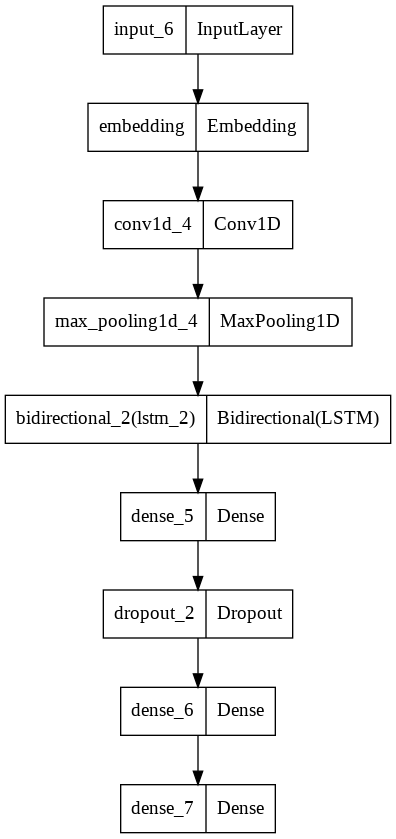

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
# Optimize the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('best-lstm-model.h5')
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

In [ ]:
X_train

array([[    0,     0,     0, ...,  1270,     1,    14],
       [    0,     0,     0, ...,  1066,    33,  3530],
       [    0,     0,     0, ...,  3531,  5329,   464],
       ...,
       [    0,     0,     0, ...,   340,  4221, 14041],
       [    0,     0,     0, ...,  1429,  1290,   242],
       [    0,     0,     0, ...,  2242,   197,   227]], dtype=int32)

In [ ]:
# Train the LSTM Model
history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb])

ValueError: ignored

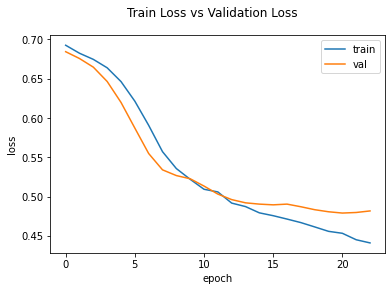

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.suptitle("Train Loss vs Validation Loss")
plt.legend(['train', 'val'])
plt.show()

In [ ]:
model = tf.keras.models.load_model('best-lstm-model.h5')

In [ ]:
sample_submission = pd.read_csv("./sample_submission.csv")
predictions = model.predict(X_test)
threshold = 0.5
sample_submission["target"] = (predictions[:,0] > threshold).astype(np.int)

In [ ]:
sample_submission.to_csv('./submission.csv', index=False)
sample_submission

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,0
3261,10874,1


In [ ]:
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "threshold 0.5"

100% 22.2k/22.2k [00:01<00:00, 12.6kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets